In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats

%matplotlib inline

In [3]:
df = pd.read_csv('../data/kc_house_data.csv')

In [4]:
pd.set_option('display.max_columns', None) #shows all columns on dataframe

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x) #applied to every df in this notebook

In [6]:
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.00,3,1.00,1180,5650,1.00,NaN,NONE,Average,7 Average,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,538000.00,3,2.25,2570,7242,2.00,NO,NONE,Average,7 Average,2170,400.0,1951,1991.00,98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,180000.00,2,1.00,770,10000,1.00,NO,NONE,Average,6 Low Average,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,604000.00,4,3.00,1960,5000,1.00,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,510000.00,3,2.00,1680,8080,1.00,NO,NONE,Average,8 Good,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.00,3,2.50,1530,1131,3.00,NO,NONE,Average,8 Good,1530,0.0,2009,0.00,98103,47.70,-122.35,1530,1509
21593,6600060120,2/23/2015,400000.00,4,2.50,2310,5813,2.00,NO,NONE,Average,8 Good,2310,0.0,2014,0.00,98146,47.51,-122.36,1830,7200
21594,1523300141,6/23/2014,402101.00,2,0.75,1020,1350,2.00,NO,NONE,Average,7 Average,1020,0.0,2009,0.00,98144,47.59,-122.30,1020,2007
21595,291310100,1/16/2015,400000.00,3,2.50,1600,2388,2.00,NaN,NONE,Average,8 Good,1600,0.0,2004,0.00,98027,47.53,-122.07,1410,1287


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

#the target would be price
#get rid of lat, long, id, condition for now 

#yr_renovate - potenital drop those na for the main analysis and come back to it to see if there is a differenc subset

#if we end up using date, change to date-time-series

#interested columns
- sqft_living15
- sqft_lot15
- grade #need to parse out since categorical 

In [8]:
df['condition'].value_counts()
#difficult to make reccomendation base off of this since there's a lot of ways to define these terms
#use grade which is a little less vague

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [9]:
df['yr_renovated'].value_counts()
#dropping columns base on the number of zeros
#potentially compared the zeros to the those that have ben renovated to see if there is a significant difference

0.00       17011
2014.00       73
2003.00       31
2013.00       31
2007.00       30
           ...  
1946.00        1
1959.00        1
1971.00        1
1951.00        1
1954.00        1
Name: yr_renovated, Length: 70, dtype: int64

In [11]:
#think that view might be important so we drop the nulls there for now
df_copy = df.copy()
df_copy['view'] = df_copy['view'].fillna(value = 'NO_RECORD')

In [12]:
df_copy = df_copy.sort_values(by=['id', 'date'])
df_copy = df_copy.drop_duplicates(subset=['id'], keep='last')

In [13]:
numbers = df_copy.select_dtypes(np.number)

In [14]:
df_2 = numbers.drop(['id', 'lat', 'long', 'zipcode'], axis = 1)

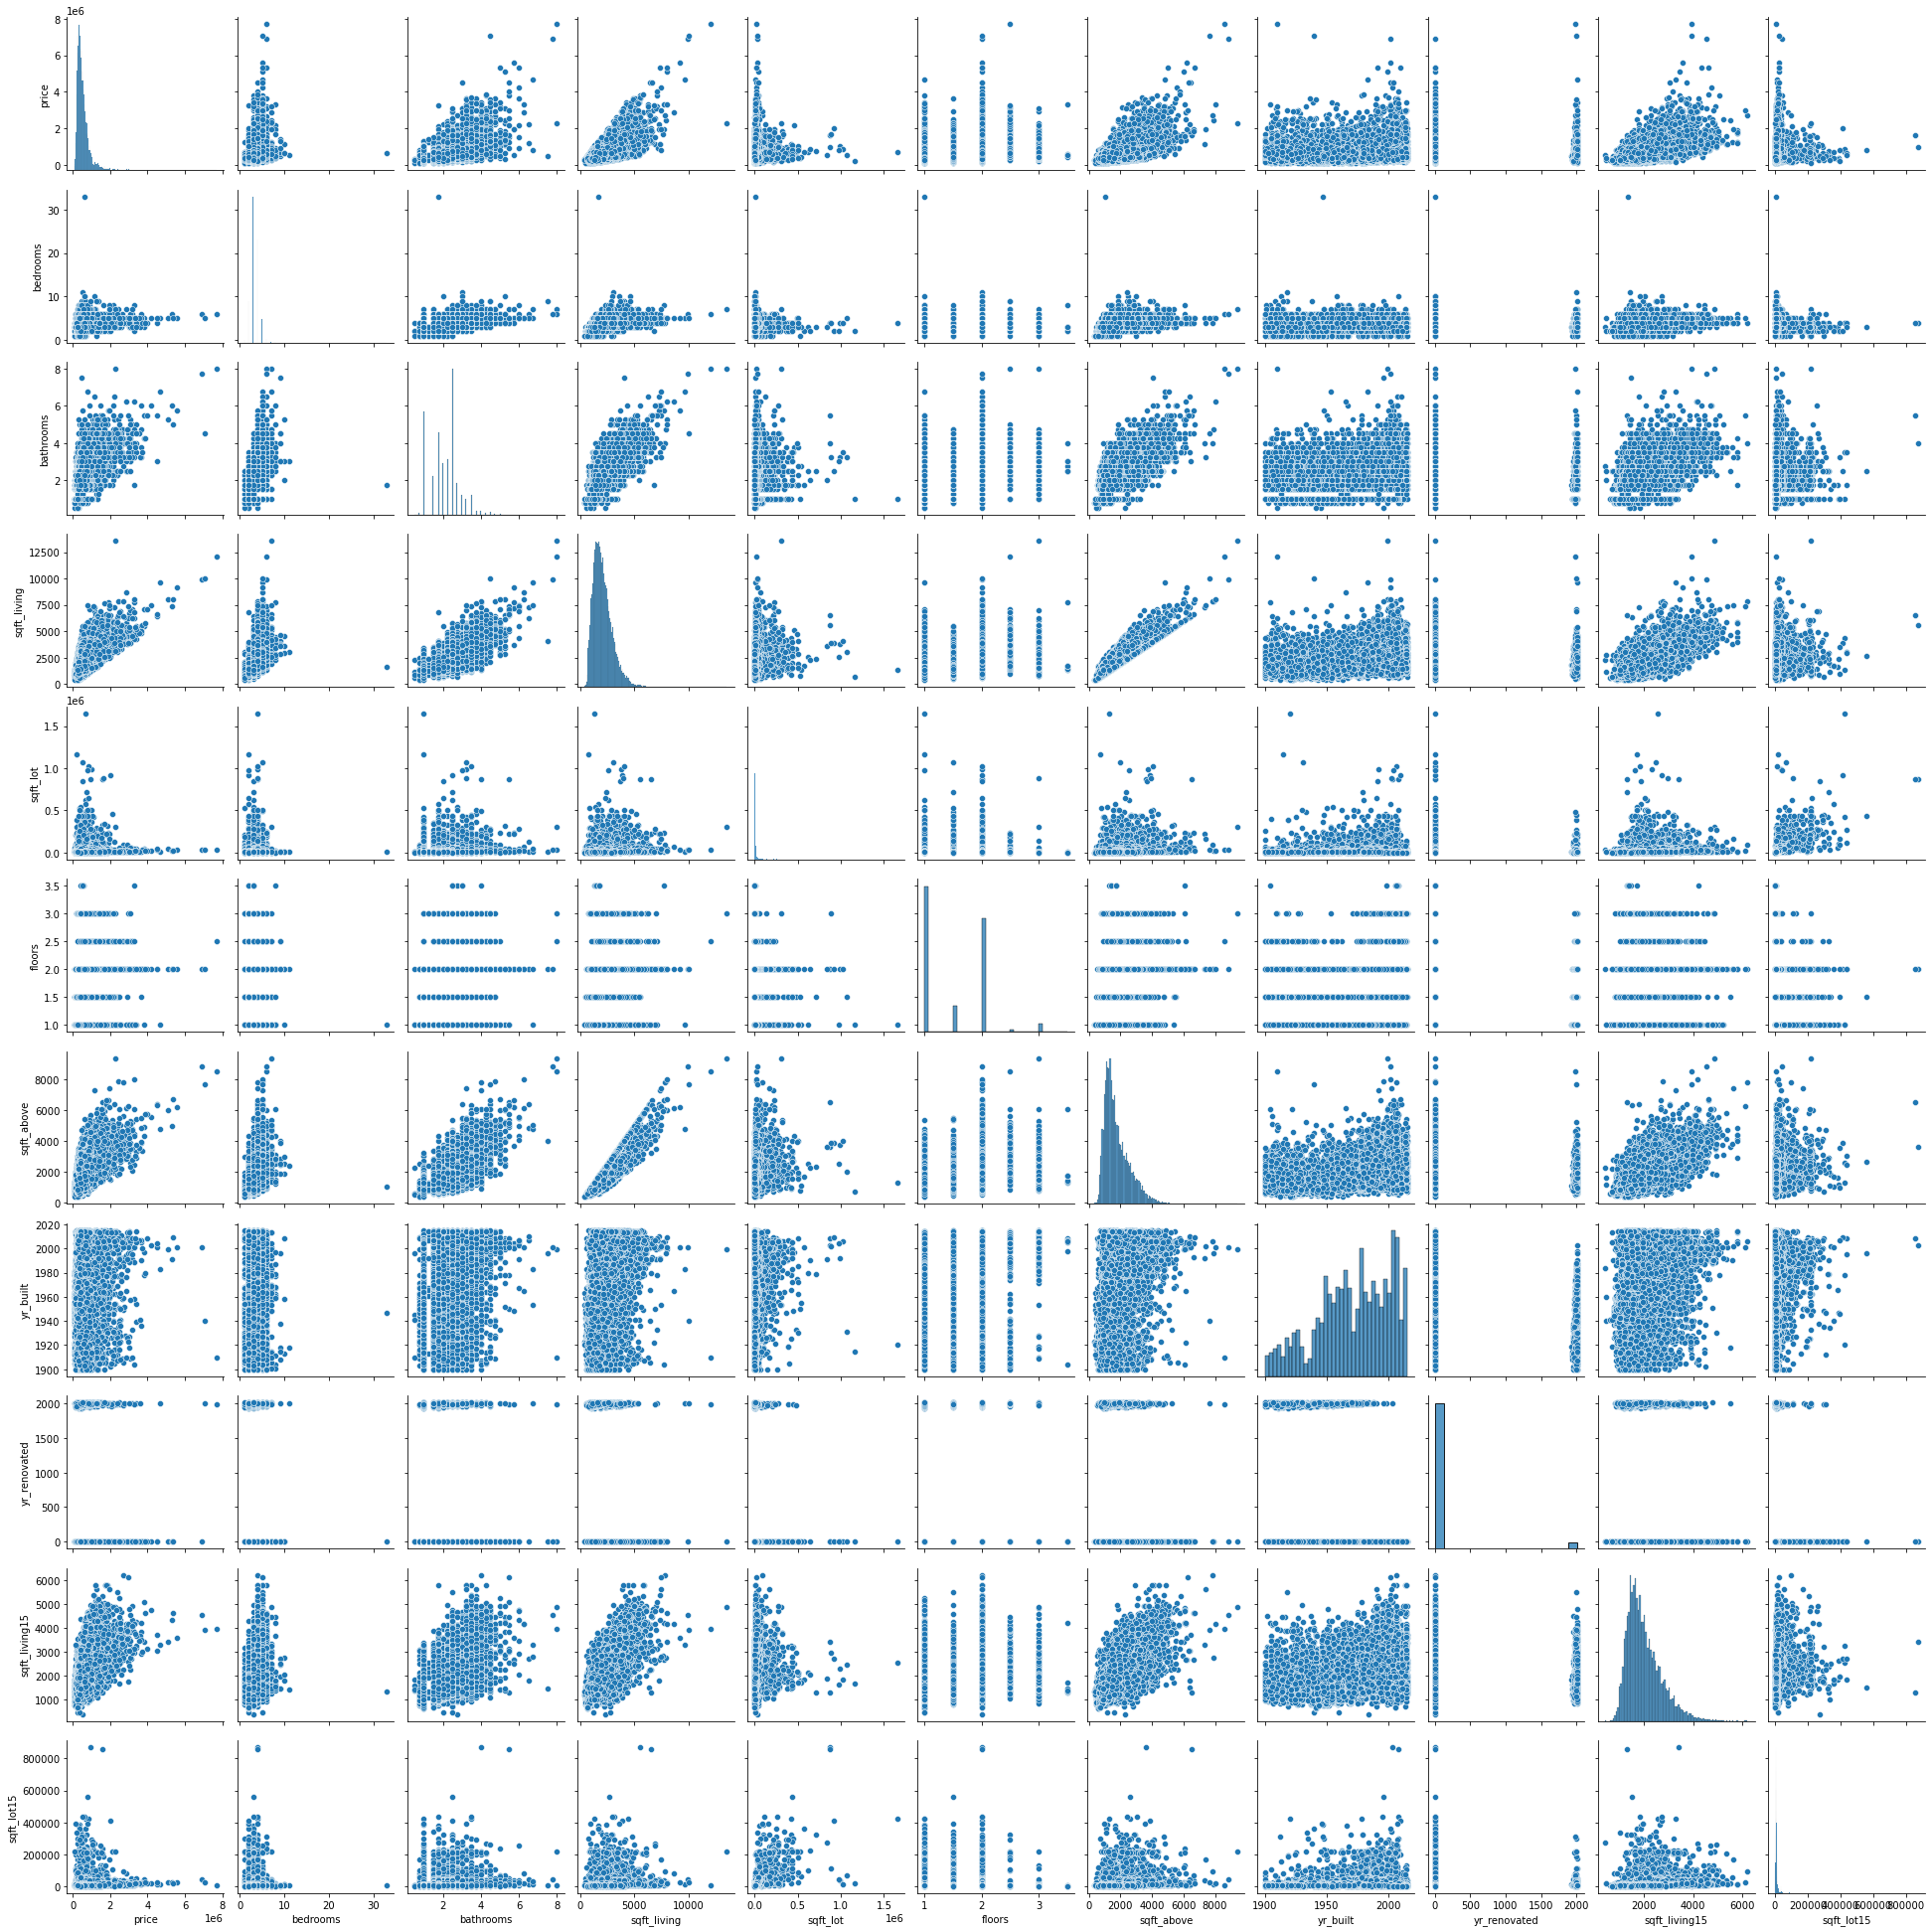

In [15]:
picture = sns.pairplot(df_2)

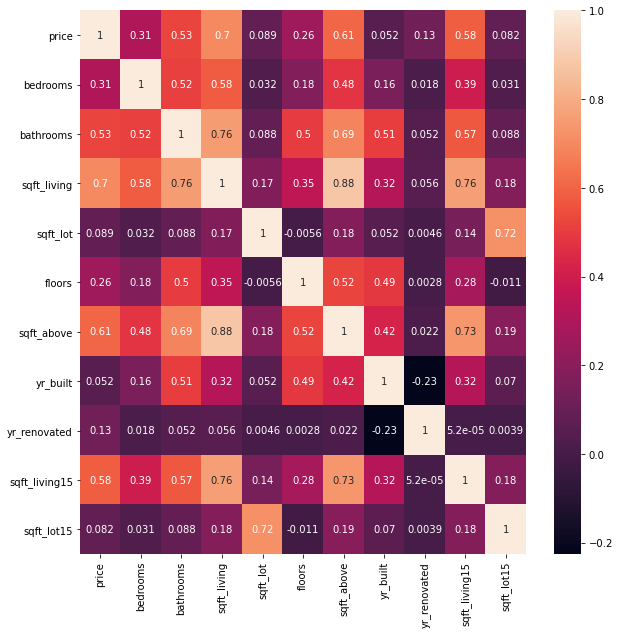

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
heat = sns.heatmap(df_2.corr(), annot = True)
#plt.savefig('heat.png',bbox = 'tight')

In [ ]:
#sqft_living has a corr of .7
#bathroom .53
# sqft_above .61
#sqft_living15 .59
#sqft_living and sqft_above have high correlation to each other .88
#sqft_living and sqft_living_living15 has high correlation .76
#sqft_living and bedrooms has .58
#sqft_living and bathroom has a correlation of .76 - multicolinearity issue?
#potentially turn sqft_living into a boolean and compare it to the sqft_living15 to see how it compares

In [ ]:
df.groupby('view').mean()

In [ ]:
#visually the price of average, fair and good look the about the same so we would need to run a significant test to see
#excellent and none looks to be potentially significant
#use of anova here to see and ad-hoc tests

In [ ]:
#drop nulls from views
df_drop_views = df.dropna(subset = ['view'])
df_drop_views

In [ ]:
df.yr_renovated.value_counts()

In [ ]:
df.yr_renovated.isna().sum()

In [ ]:
df.yr_renovated.fillna(value = 0, inplace = True)
#fill them with zero, might be mention in the next step to look at
#for now we can drop 

In [ ]:
len(numbers['id'].unique())

In [ ]:
copy_df = df.copy()

In [ ]:
df.head()

In [ ]:
trial = copy_df.groupby(['id']).date.transform(max)
trial_cleaned = copy_df[copy_df.id == trial]

In [ ]:
#making the categorical variable
cate_column = df_drop_views[['grade', 'view']]

In [ ]:
#ohe = OneHotEncoder(drop='first')

#columns_name2 = ['weekday', 'weathersit']
#scale_features2 = .copy()

#features2= scale_features2[columns_name2]

#scale3 = ohe.fit_transform(features2)

In [ ]:
ohe = OneHotEncoder(drop='first')

column_name = ['grade', 'view']
features = cate_column.copy()

features2 = features[column_name]

cate_ohe = ohe.fit_transform(features2)

cate_ohe

In [ ]:
name = ohe.get_feature_names()

In [ ]:
cate_parsed = pd.DataFrame(cate_ohe.todense(), columns = name)

In [ ]:
cate_parsed
#X0 = grade
#x1 = view

In [ ]:
df_2.head(1)

In [ ]:
#scaling our numerical values


In [ ]:
df_2

In [ ]:
#to potentially drop sqft_lot and sqft_lot15
ss = StandardScaler()
#scaled_ = ss.fit_transform(df_2)

columns_name1 = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_above']
numbers_scaling = df_2.copy()

features= numbers_scaling[columns_name1]

scale1 = ss.fit(features)
scale2 = scale1.transform(features)
numbers_scaling[columns_name1] = scale2

numbers_scaling

In [ ]:
df_2

In [ ]:
pd.concat([numbers_scaling, cate_parsed], axis = 1)